**set up of the enviromnment**

In [ ]:
# ============================================================
# CELL 1: COMPLETE SETUP, IMPORTS & CONFIGURATION
# ============================================================
# Run this cell first to set up your environment

print("🚀 Starting ASL Recognition System Setup...")
print("="*60)

# ==================== INSTALL PACKAGES ====================
print("\n📦 Installing required packages...")
!pip install -q kagglehub tensorflow opencv-python-headless mediapipe scikit-learn seaborn

# ==================== IMPORTS ====================
print("📚 Importing libraries...")
import os
import gc
import time
from base64 import b64decode
from collections import deque, Counter

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
import mediapipe as mp
import tensorflow as tf

from IPython.display import display, Javascript, clear_output
from google.colab import drive
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js

print("✅ All libraries imported successfully")

# ==================== MOUNT GOOGLE DRIVE ====================
print("\n💾 Mounting Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
    print("✅ Google Drive mounted successfully")
except Exception as e:
    print(f"⚠️ Warning: Could not mount Google Drive - {e}")

# ==================== GPU SETUP ====================
print("\n🎮 Configuring GPU...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Found {len(gpus)} GPU(s)")
    for i, gpu in enumerate(gpus):
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"   GPU {i}: {gpu.name} - Memory growth enabled")
        except Exception as e:
            print(f"   Warning setting memory growth on GPU {i}: {e}")
else:
    print("⚠️ No GPU detected - training will use CPU (slower)")

# ==================== MIXED PRECISION ====================
print("\n⚡ Setting up mixed precision...")
try:
    from tensorflow.keras import mixed_precision
    if gpus:
        mixed_precision.set_global_policy('mixed_float16')
        print(f"✅ Mixed precision enabled: {mixed_precision.global_policy()}")
        print("   This will speed up training on modern GPUs")
    else:
        print("⏭️ Skipping mixed precision (no GPU detected)")
except Exception as e:
    print(f"⚠️ Mixed precision unavailable: {e}")

# ==================== CONFIGURATION CLASS ====================
print("\n⚙️ Initializing configuration...")

class Config:
    """Complete configuration for ASL Recognition System"""

    # ===== Dataset Settings =====
    DATASET_SLUG = "debashishsau/aslamerican-sign-language-aplhabet-dataset"
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.2
    SEED = 42

    # ===== Model Paths =====
    MODEL_DIR = "/content/drive/MyDrive/asl_training_saves"
    MODEL_NAME = "asl_model"
    MODEL_PATH_KERAS = os.path.join(MODEL_DIR, "asl_model_final.keras")
    MODEL_PATH_H5 = os.path.join(MODEL_DIR, "asl_model_final.h5")

    # ===== Training Paths =====
    CHECKPOINT_STAGE1 = os.path.join(MODEL_DIR, "asl_model_stage1.keras")
    CHECKPOINT_STAGE2 = os.path.join(MODEL_DIR, "asl_model_stage2.keras")
    HISTORY_STAGE1 = os.path.join(MODEL_DIR, "asl_history_stage1.pkl")
    HISTORY_STAGE2 = os.path.join(MODEL_DIR, "asl_history_stage2.pkl")

    # ===== Prediction Settings =====
    SMOOTH_WINDOW = 5           # Number of predictions to smooth over
    CONFIDENCE_THRESHOLD = 0.60 # Minimum confidence for prediction
    HOLD_FRAMES = 8             # Frames to hold before accepting new letter

    # ===== Label Map (populated after dataset loading) =====
    LABEL_MAP = {}

# Create model directory if it doesn't exist
os.makedirs(Config.MODEL_DIR, exist_ok=True)
print(f"✅ Model directory: {Config.MODEL_DIR}")

# ==================== SYSTEM INFO ====================
print("\n" + "="*60)
print("📊 SYSTEM INFORMATION")
print("="*60)
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Python version: {os.sys.version.split()[0]}")
print(f"GPU available: {'Yes' if gpus else 'No'}")
if gpus:
    print(f"GPU count: {len(gpus)}")
print("="*60)

# ==================== CONFIGURATION SUMMARY ====================
print("\n📋 CONFIGURATION SUMMARY")
print("="*60)
print(f"Image size: {Config.IMG_SIZE}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Validation split: {Config.VALIDATION_SPLIT:.0%}")
print(f"Random seed: {Config.SEED}")
print(f"Confidence threshold: {Config.CONFIDENCE_THRESHOLD:.0%}")
print(f"Smooth window: {Config.SMOOTH_WINDOW} frames")
print(f"Hold frames: {Config.HOLD_FRAMES} frames")
print("="*60)

print("\n✅ Setup complete! Ready to proceed.")
print("📌 Next step: Run Cell 2 to download dataset")
print("="*60)

🚀 Starting ASL Recognition System Setup...

📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
📚 Importing libraries...
✅ All libraries imported successfully

💾 Mounting Google Drive...
Mounted at /content/drive
✅ Google Drive mounted successfully

🎮 Configuring GPU...
✅ Found 1 GPU(s)
   GPU 0: /physical_device:GPU:0 - Memory growth enabled

⚡ Setting up mixed preci

In [ ]:
from google.colab import drive


!ls "/content/drive/MyDrive/asl_training_saves"



**download the data set**

In [ ]:
# ============================================================
# CELL 2: DATASET DOWNLOAD & PATH DETECTION
# ============================================================
# This cell downloads the ASL dataset and finds the training directory

import os
import kagglehub
import zipfile

print("🚀 Starting dataset download...")
print("="*60)

# ==================== CREATE MODEL DIRECTORY ====================
print("\n📁 Setting up directories...")
os.makedirs(Config.MODEL_DIR, exist_ok=True)
print(f"✅ Model directory ready: {Config.MODEL_DIR}")

# ==================== DOWNLOAD DATASET ====================
print("\n📥 Downloading Kaggle dataset...")
print(f"Dataset: {Config.DATASET_SLUG}")
dataset_path = kagglehub.dataset_download(Config.DATASET_SLUG)
print(f"✅ Dataset downloaded at: {dataset_path}")

# ==================== UNZIP IF NEEDED ====================
if dataset_path.endswith('.zip'):
    extract_dir = dataset_path.replace(".zip", "")
    if not os.path.exists(extract_dir):
        print("\n📦 Extracting dataset...")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✅ Dataset extracted at: {extract_dir}")
    else:
        print(f"✅ Dataset already extracted at: {extract_dir}")
else:
    extract_dir = dataset_path
    print(f"✅ Dataset path: {extract_dir}")

# ==================== TRAIN DIRECTORY DETECTION ====================
print("\n🔍 Searching for training directory...")

train_dir = None
candidates = [
    "asl_alphabet_train",
    "asl_alphabet_train/asl_alphabet_train",
    "asl_alphabet_train/train",
    "train",
    "asl_alphabet"
]

# Try standard paths first
for root, dirs, files in os.walk(extract_dir):
    for cand in candidates:
        cand_path = os.path.join(root, cand)
        if os.path.isdir(cand_path):
            train_dir = cand_path
            print(f"   Found candidate: {cand}")
            break
    if train_dir:
        break

# Fallback: find any folder with many subfolders (likely class folders)
if not train_dir:
    print("⚠️ Standard directories not found, searching for folder with multiple classes...")
    for root, dirs, files in os.walk(extract_dir):
        if len(dirs) >= 10:  # At least 10 class folders
            train_dir = root
            print(f"   Found folder with {len(dirs)} subfolders")
            break

if not train_dir:
    raise FileNotFoundError(
        "❌ Training folder not found inside dataset.\n"
        f"   Dataset path: {extract_dir}\n"
        "   Please check dataset structure manually."
    )

print(f"✅ Training directory found: {train_dir}")

# ==================== LIST CLASSES ====================
print("\n📊 Analyzing dataset structure...")

# Get class names from directory structure
class_names = sorted([d for d in os.listdir(train_dir)
                     if os.path.isdir(os.path.join(train_dir, d))])

print(f"\n📋 Dataset Information:")
print(f"   Number of classes: {len(class_names)}")
print(f"   Classes: {class_names}")

# Count images per class
print("\n📸 Counting images per class...")
class_image_counts = {}
total_images = 0

for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    num_images = len([f for f in os.listdir(class_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    class_image_counts[class_name] = num_images
    total_images += num_images

print(f"   Total images: {total_images:,}")
print(f"   Images per class: ~{total_images // len(class_names):,}")

# Show first few classes as sample
print("\n📌 Sample class counts:")
for i, (class_name, count) in enumerate(list(class_image_counts.items())[:5]):
    print(f"   {class_name}: {count:,} images")
if len(class_image_counts) > 5:
    print(f"   ... and {len(class_image_counts) - 5} more classes")

# ==================== POPULATE LABEL MAP ====================
print("\n🏷️ Creating label map...")
Config.LABEL_MAP = {i: name for i, name in enumerate(class_names)}
print(f"✅ Label map created with {len(Config.LABEL_MAP)} classes")

# Verify label map
print("\n📋 Label Map (first 10):")
for i in range(min(10, len(Config.LABEL_MAP))):
    print(f"   {i}: {Config.LABEL_MAP[i]}")
if len(Config.LABEL_MAP) > 10:
    print(f"   ... and {len(Config.LABEL_MAP) - 10} more")

# ==================== SUMMARY ====================
print("\n" + "="*60)
print("✅ DATASET READY!")
print("="*60)
print(f"📂 Training directory: {train_dir}")
print(f"📊 Total classes: {len(class_names)}")
print(f"📸 Total images: {total_images:,}")
print(f"📈 Train/Val split: {1-Config.VALIDATION_SPLIT:.0%} / {Config.VALIDATION_SPLIT:.0%}")
print(f"🎯 Expected train images: ~{int(total_images * (1-Config.VALIDATION_SPLIT)):,}")
print(f"🎯 Expected val images: ~{int(total_images * Config.VALIDATION_SPLIT):,}")
print("="*60)
print("📌 Next: Run Cell 3 to create data pipeline")
print("="*60)

🚀 Starting dataset download...

📁 Setting up directories...
✅ Model directory ready: /content/drive/MyDrive/asl_training_saves

📥 Downloading Kaggle dataset...
Dataset: debashishsau/aslamerican-sign-language-aplhabet-dataset


100%|██████████| 4.20G/4.20G [03:15<00:00, 23.1MB/s]

Extracting files...


✅ Dataset downloaded at: /root/.cache/kagglehub/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset/versions/1
✅ Dataset path: /root/.cache/kagglehub/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset/versions/1

🔍 Searching for training directory...
   Found candidate: asl_alphabet_train
✅ Training directory found: /root/.cache/kagglehub/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset/versions/1/ASL_Alphabet_Dataset/asl_alphabet_train

📊 Analyzing dataset structure...

📋 Dataset Information:
   Number of classes: 29
   Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

📸 Counting images per class...
   Total images: 223,074
   Images per class: ~7,692

📌 Sample class counts:
   A: 8,458 images
   B: 8,309 images
   C: 8,146 images
   D: 7,629 images
   E: 7,744 images
   ... and 24 more classes

🏷️ Creating label map...
✅ Labe

**data prepration**

In [ ]:

# ==================== CELL 3: FIXED DATA PIPELINE ====================
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

print("\n🚀 Building FIXED tf.data pipeline...")

# === GET IMAGE PATHS AND LABELS ===
def get_image_paths_and_labels(train_dir):
    """Efficiently get all image paths and labels"""
    image_paths, labels = [], []
    class_names = sorted([d for d in os.listdir(train_dir)
                         if os.path.isdir(os.path.join(train_dir, d))])
    print(f"Found {len(class_names)} classes: {class_names[:5]}...")
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(class_to_idx[class_name])
    return image_paths, labels, class_names

image_paths, labels, class_names = get_image_paths_and_labels(train_dir)
num_classes = len(class_names)

print(f"✓ Total images: {len(image_paths)}")
print(f"✓ Classes: {num_classes}")
Config.LABEL_MAP = {i: name for i, name in enumerate(class_names)}

# === SPLIT TRAIN/VAL ===
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels,
    test_size=Config.VALIDATION_SPLIT,
    stratify=labels,
    random_state=Config.SEED
)
print(f"✓ Train: {len(train_paths)}, Val: {len(val_paths)}")

# === DATA AUGMENTATION ===
@tf.function
def augment_image(image):
    """Fast augmentation using tf operations"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # Removed rot90 - causes shape issues
    return image

# === LOAD + PREPROCESS ===
def load_and_preprocess(path, label, augment=False):
    """Load and preprocess image - NOT @tf.function to avoid issues"""
    # Read image
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, Config.IMG_SIZE)

    # Augment if training
    if augment:
        image = augment_image(image)

    # MobileNetV2 preprocessing
    image = preprocess_input(image)

    # One-hot encode label
    label = tf.one_hot(label, num_classes)

    return image, label

# === CREATE DATASETS (FIXED VERSION) ===
AUTOTUNE = tf.data.AUTOTUNE

# Training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.cache()  # Cache after loading paths
train_ds = train_ds.shuffle(buffer_size=len(train_paths), seed=Config.SEED, reshuffle_each_iteration=True)
train_ds = train_ds.map(
    lambda x, y: load_and_preprocess(x, y, augment=True),
    num_parallel_calls=AUTOTUNE
)
train_ds = train_ds.batch(Config.BATCH_SIZE, drop_remainder=False)  # Don't drop remainder
train_ds = train_ds.repeat()  # CRITICAL: Repeat indefinitely
train_ds = train_ds.prefetch(AUTOTUNE)

# Validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.cache()
val_ds = val_ds.map(
    lambda x, y: load_and_preprocess(x, y, augment=False),
    num_parallel_calls=AUTOTUNE
)
val_ds = val_ds.batch(Config.BATCH_SIZE, drop_remainder=False)
val_ds = val_ds.repeat()  # CRITICAL: Repeat indefinitely
val_ds = val_ds.prefetch(AUTOTUNE)

# Calculate steps CORRECTLY
steps_per_epoch = len(train_paths) // Config.BATCH_SIZE
validation_steps = len(val_paths) // Config.BATCH_SIZE

print(f"\n✅ FIXED tf.data pipeline ready!")
print(f"   Train samples: {len(train_paths)}")
print(f"   Val samples: {len(val_paths)}")
print(f"   Steps per epoch: {steps_per_epoch}")
print(f"   Validation steps: {validation_steps}")
print(f"   Batch size: {Config.BATCH_SIZE}")
print(f"   🔧 Added .repeat() to prevent data exhaustion!")



🚀 Building FIXED tf.data pipeline...
Found 29 classes: ['A', 'B', 'C', 'D', 'E']...
✓ Total images: 223074
✓ Classes: 29
✓ Train: 178459, Val: 44615

✅ FIXED tf.data pipeline ready!
   Train samples: 178459
   Val samples: 44615
   Steps per epoch: 5576
   Validation steps: 1394
   Batch size: 32
   🔧 Added .repeat() to prevent data exhaustion!


***build the model***

In [ ]:
# === CELL 4: MODEL BUILDING (MobileNetV2) + CALLBACKS ===

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.applications import MobileNetV2

print("\n🏗️ Building MobileNetV2 model (base, include_top=False)")

base_model = MobileNetV2(
    input_shape=(Config.IMG_SIZE[0], Config.IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet',
    alpha=1.0
)


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

print(f"Total params: {model.count_params():,}")

# Callbacks
checkpoint = ModelCheckpoint(
    Config.MODEL_PATH_KERAS,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Also save an h5 copy in a callback end-of-training (we'll call model.save after training)
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

print("✅ Model and callbacks ready.")



🏗️ Building MobileNetV2 model (base, include_top=False)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Total params: 2,930,781
✅ Model and callbacks ready.


In [ ]:
print(train_ds.class_names)
print(len(train_ds.class_names))


**train the model**

In [ ]:
# ==================== CELL 2: STAGE 1 TRAIN (BASE FROZEN) ====================
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
from tensorflow.keras.optimizers import Adam
import pickle, os, gc, time

print("\n" + "="*60)
print("STAGE 1: Training classifier (base frozen)")
print("="*60)

# === PATHS ===
drive_path = "/content/drive/MyDrive/asl_training_saves"
os.makedirs(drive_path, exist_ok=True)
checkpoint_path = os.path.join(drive_path, "asl_model_stage1.keras")
history_path = os.path.join(drive_path, "asl_history_stage1.pkl")

# === EXISTING MODEL CHECK ===
if os.path.exists(checkpoint_path):
    print(f"⚠️ Found existing model at {checkpoint_path}")
    load_existing = input("Load existing model? (y/n): ").lower()
    if load_existing == 'y':
        from tensorflow.keras.models import load_model
        model = load_model(checkpoint_path)
        print("✅ Loaded existing model!")
        if os.path.exists(history_path):
            with open(history_path, "rb") as f:
                history1 = pickle.load(f)
            print("✅ Loaded training history!")
        print("⏭️ Skip to fine-tuning (Cell 3)")
    else:
        print("Training new model...")
else:
    print("No existing model found. Training from scratch...")

# === CALLBACKS ===
checkpoint_cb = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
start_time = time.time()
time_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"⏱️ Epoch {epoch+1} done. Total time: {(time.time()-start_time)/60:.1f} min"))
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1)

# === COMPILE ===
base_model.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

print(f"\n🎯 Training for max 15 epochs...")
print(f"   Batch size: {Config.BATCH_SIZE}")
print(f"   Steps per epoch: {steps_per_epoch}")

# === TRAIN ===
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint_cb, time_cb, early_stop],
    verbose=1
)

# === SAVE ===
with open(history_path, "wb") as f:
    pickle.dump(history1.history, f)

best_acc = max(history1.history.get("val_accuracy", [0]))
total_time = (time.time() - start_time) / 60
print(f"\n✅ Stage 1 Complete!")
print(f"   Best val accuracy: {best_acc:.4f}")
print(f"   Total time: {total_time:.1f} minutes")
print(f"   📁 Model: {checkpoint_path}")
gc.collect()
tf.keras.backend.clear_session()


**fune tunning**

In [ ]:
import os, gc, pickle, time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("STAGE 2: Fine-tuning (unfreeze last layers)")
print("="*60)

# === PATHS ===
drive_path = "/content/drive/MyDrive/asl_training_saves"
checkpoint_path_stage1 = os.path.join(drive_path, "asl_model_stage1.keras")
checkpoint_path_stage2 = os.path.join(drive_path, "asl_model_stage2.keras")
history_path_stage2 = os.path.join(drive_path, "asl_history_stage2.pkl")

# === LOAD MODEL ===
if os.path.exists(checkpoint_path_stage1):
    print("📦 Loading Stage 1 model...")
    model = load_model(checkpoint_path_stage1)
    print("✅ Loaded!")
else:
    print("⚠️ Using current model...")

# === UNFREEZE ===
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

trainable = sum([1 for layer in model.layers if hasattr(layer, 'trainable') and layer.trainable])
print(f"Trainable layers: {trainable}")

# === COMPILE ===
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# === CALLBACKS ===
checkpoint_cb2 = ModelCheckpoint(
    checkpoint_path_stage2,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_stop2 = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

start_time = time.time()
print(f"\n🎯 Fine-tuning for max 15 epochs...")

# === TRAIN (FIXED) ===
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    steps_per_epoch=steps_per_epoch,  # CRITICAL
    validation_steps=validation_steps,  # CRITICAL
    callbacks=[checkpoint_cb2, early_stop2, reduce_lr],
    verbose=1
)

# === SAVE ===



STAGE 2: Fine-tuning (unfreeze last layers)
📦 Loading Stage 1 model...
✅ Loaded!
Trainable layers: 6

🎯 Fine-tuning for max 15 epochs...
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


  12/5576 ━━━━━━━━━━━━━━━━━━━━ 2:17:50 1s/step - accuracy: 0.9515 - loss: 0.1497

KeyboardInterrupt: 

In [ ]:
# ============================================================
# LOAD PRE-TRAINED MODEL (SKIP TRAINING)
# ============================================================
# Run this cell instead of training if your model is already saved

from tensorflow.keras.models import load_model
import pickle
import os

print("\n" + "="*60)
print("Loading Pre-Trained Model (Skipping Training)")
print("="*60)

# === PATHS ===
drive_path = "/content/drive/MyDrive/asl_training_saves"
checkpoint_path_stage1 = os.path.join(drive_path, "asl_model_stage1.keras")
checkpoint_path_stage2 = os.path.join(drive_path, "asl_model_stage2.keras")
history_path_stage1 = os.path.join(drive_path, "asl_history_stage1.pkl")
history_path_stage2 = os.path.join(drive_path, "asl_history_stage2.pkl")

# === FIND BEST MODEL ===
print("\n🔍 Looking for trained models...")

model_path = None
if os.path.exists(checkpoint_path_stage2):
    model_path = checkpoint_path_stage2
    print(f"✅ Found Stage 2 (fine-tuned) model")
elif os.path.exists(checkpoint_path_stage1):
    model_path = checkpoint_path_stage1
    print(f"✅ Found Stage 1 model")
else:
    raise FileNotFoundError(
        "❌ No trained model found!\n"
        f"Looked for:\n"
        f"  - {checkpoint_path_stage2}\n"
        f"  - {checkpoint_path_stage1}"
    )

# === LOAD MODEL ===
print(f"\n📦 Loading model from:\n   {model_path}")
model = load_model(model_path)
print("✅ Model loaded successfully!")

# Get model info
num_classes = model.output_shape[-1]
print(f"\n📊 Model Info:")
print(f"   Classes: {num_classes}")
print(f"   Parameters: {model.count_params():,}")

# === LOAD TRAINING HISTORIES ===
print(f"\n📈 Loading training histories...")

# Load Stage 1
if os.path.exists(history_path_stage1):
    with open(history_path_stage1, "rb") as f:
        history1 = pickle.load(f)
    print(f"✅ Stage 1: {len(history1.get('accuracy', []))} epochs")
else:
    print("⚠️ Stage 1 history not found")
    history1 = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Load Stage 2
if os.path.exists(history_path_stage2):
    with open(history_path_stage2, "rb") as f:
        history2 = pickle.load(f)
    print(f"✅ Stage 2: {len(history2.get('accuracy', []))} epochs")
else:
    print("⚠️ Stage 2 history not found")
    history2 = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# === VERIFY LABEL MAP ===
print(f"\n🏷️ Checking label map...")
if Config.LABEL_MAP and len(Config.LABEL_MAP) == num_classes:
    print(f"✅ Label map OK ({len(Config.LABEL_MAP)} classes)")
else:
    print(f"⚠️ WARNING: Label map issue!")
    print(f"   Model has {num_classes} classes")
    print(f"   Label map has {len(Config.LABEL_MAP)} classes")
    print("\n❌ You MUST run Cell 2 (Dataset Download) to fix this!")

# === SUMMARY ===
all_val_acc = history1.get('val_accuracy', []) + history2.get('val_accuracy', [])
if all_val_acc:
    best_acc = max(all_val_acc)
    final_acc = all_val_acc[-1]

    print("\n" + "="*60)
    print("📊 TRAINING RESULTS")
    print("="*60)
    print(f"🏆 Best accuracy: {best_acc:.4f} ({best_acc:.2%})")
    print(f"📈 Final accuracy: {final_acc:.4f} ({final_acc:.2%})")
    print(f"📊 Total epochs: {len(all_val_acc)}")
    print("="*60)

print("\n✅ READY TO USE!")
print("="*60)
print("You can now run:")
print("  ✓ Plotting cell (visualize training)")
print("  ✓ Confusion matrix cell (detailed evaluation)")
print("  ✓ Live prediction cell (test on camera)")
print("="*60)


Loading Pre-Trained Model (Skipping Training)

🔍 Looking for trained models...
✅ Found Stage 2 (fine-tuned) model

📦 Loading model from:
   /content/drive/MyDrive/asl_training_saves/asl_model_stage2.keras
✅ Model loaded successfully!

📊 Model Info:
   Classes: 29
   Parameters: 2,930,781

📈 Loading training histories...
✅ Stage 1: 15 epochs
✅ Stage 2: 15 epochs

🏷️ Checking label map...
✅ Label map OK (29 classes)

📊 TRAINING RESULTS
🏆 Best accuracy: 0.9917 (99.17%)
📈 Final accuracy: 0.9917 (99.17%)
📊 Total epochs: 30

✅ READY TO USE!
You can now run:
  ✓ Plotting cell (visualize training)
  ✓ Confusion matrix cell (detailed evaluation)
  ✓ Live prediction cell (test on camera)


**plotting**


📊 Plotting training history...
✅ Plotting 30 epochs of training


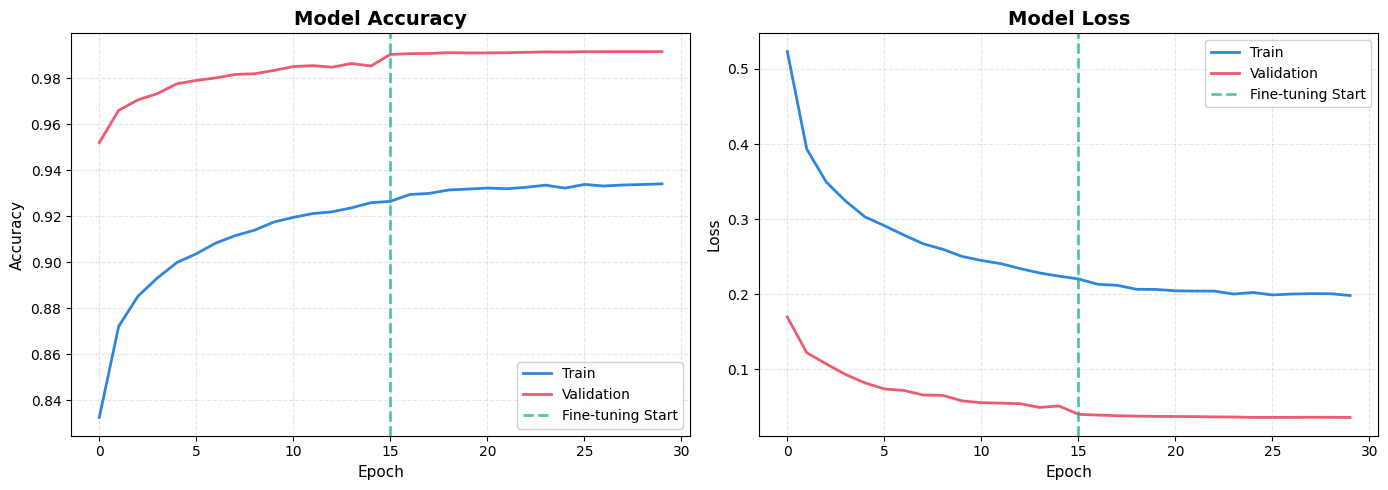


📊 TRAINING METRICS SUMMARY
Total Epochs: 30
  - Stage 1 (frozen): 15 epochs
  - Stage 2 (fine-tuned): 15 epochs

📈 Final Validation Accuracy: 0.9917 (99.17%)
🏆 Best Validation Accuracy:  0.9917 (99.17%)

📉 Final Validation Loss: 0.0360
🏆 Best Validation Loss:  0.0360

💡 Fine-tuning Impact:
   Stage 1 best: 98.65%
   Stage 2 best: 99.17%
   Improvement:  +0.52 percentage points

✅ Plotting complete!
📌 Next: Run confusion matrix cell for detailed evaluation


In [ ]:
# ============================================================
# CELL 7: PLOT TRAINING METRICS
# ============================================================

import matplotlib.pyplot as plt

print("\n📊 Plotting training history...")
print("="*60)

# === FIX: Handle both dict and History object ===
# If history1/history2 are History objects, extract .history
if hasattr(history1, 'history'):
    hist1 = history1.history
else:
    hist1 = history1

if hasattr(history2, 'history'):
    hist2 = history2.history
else:
    hist2 = history2

# === COMBINE HISTORIES ===
combined = {
    'accuracy': hist1.get('accuracy', []) + hist2.get('accuracy', []),
    'val_accuracy': hist1.get('val_accuracy', []) + hist2.get('val_accuracy', []),
    'loss': hist1.get('loss', []) + hist2.get('loss', []),
    'val_loss': hist1.get('val_loss', []) + hist2.get('val_loss', [])
}

# Check if we have data
if not combined['accuracy']:
    print("⚠️ No training history available to plot")
    print("   Make sure training is complete or histories are loaded")
else:
    print(f"✅ Plotting {len(combined['accuracy'])} epochs of training")

    # === CREATE PLOT ===
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ACCURACY PLOT
    axes[0].plot(combined['accuracy'], label='Train', linewidth=2, color='#2E86DE')
    axes[0].plot(combined['val_accuracy'], label='Validation', linewidth=2, color='#EE5A6F')

    # Add vertical line at stage transition
    if hist1.get('accuracy'):
        stage1_epochs = len(hist1.get('accuracy', []))
        axes[0].axvline(x=stage1_epochs, color='#10AC84', linestyle='--',
                       linewidth=2, alpha=0.7, label='Fine-tuning Start')

    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Accuracy', fontsize=11)
    axes[0].legend(loc='lower right', framealpha=0.9)
    axes[0].grid(True, alpha=0.3, linestyle='--')

    # LOSS PLOT
    axes[1].plot(combined['loss'], label='Train', linewidth=2, color='#2E86DE')
    axes[1].plot(combined['val_loss'], label='Validation', linewidth=2, color='#EE5A6F')

    # Add vertical line at stage transition
    if hist1.get('loss'):
        stage1_epochs = len(hist1.get('loss', []))
        axes[1].axvline(x=stage1_epochs, color='#10AC84', linestyle='--',
                       linewidth=2, alpha=0.7, label='Fine-tuning Start')

    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Loss', fontsize=11)
    axes[1].legend(loc='upper right', framealpha=0.9)
    axes[1].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

    # === STATISTICS ===
    final_acc = combined['val_accuracy'][-1] if combined['val_accuracy'] else 0
    best_acc = max(combined['val_accuracy']) if combined['val_accuracy'] else 0
    final_loss = combined['val_loss'][-1] if combined['val_loss'] else 0
    best_loss = min(combined['val_loss']) if combined['val_loss'] else 0

    print("\n" + "="*60)
    print("📊 TRAINING METRICS SUMMARY")
    print("="*60)
    print(f"Total Epochs: {len(combined['accuracy'])}")
    print(f"  - Stage 1 (frozen): {len(hist1.get('accuracy', []))} epochs")
    print(f"  - Stage 2 (fine-tuned): {len(hist2.get('accuracy', []))} epochs")
    print()
    print(f"📈 Final Validation Accuracy: {final_acc:.4f} ({final_acc:.2%})")
    print(f"🏆 Best Validation Accuracy:  {best_acc:.4f} ({best_acc:.2%})")
    print()
    print(f"📉 Final Validation Loss: {final_loss:.4f}")
    print(f"🏆 Best Validation Loss:  {best_loss:.4f}")

    # Show improvement from fine-tuning
    if hist1.get('val_accuracy') and hist2.get('val_accuracy'):
        stage1_best = max(hist1.get('val_accuracy', [0]))
        stage2_best = max(hist2.get('val_accuracy', [0]))
        improvement = (stage2_best - stage1_best) * 100

        print()
        print("💡 Fine-tuning Impact:")
        print(f"   Stage 1 best: {stage1_best:.2%}")
        print(f"   Stage 2 best: {stage2_best:.2%}")
        print(f"   Improvement:  {improvement:+.2f} percentage points")

    print("="*60)

print("\n✅ Plotting complete!")
print("📌 Next: Run confusion matrix cell for detailed evaluation")

**confession matrix**


MODEL EVALUATION
✅ Found 29 classes
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

🔍 Generating predictions (this may take a while)...
   Processed 20/1394 batches...
   Processed 40/1394 batches...
   Processed 60/1394 batches...
   Processed 80/1394 batches...
   Processed 100/1394 batches...
   Processed 120/1394 batches...
   Processed 140/1394 batches...
   Processed 160/1394 batches...
   Processed 180/1394 batches...
   Processed 200/1394 batches...
   Processed 220/1394 batches...
   Processed 240/1394 batches...
   Processed 260/1394 batches...
   Processed 280/1394 batches...
   Processed 300/1394 batches...
   Processed 320/1394 batches...
   Processed 340/1394 batches...
   Processed 360/1394 batches...
   Processed 380/1394 batches...
   Processed 400/1394 batches...
   Processed 420/1394 batches...
   Processed 440/1394 batches...
   Processed 460/1394

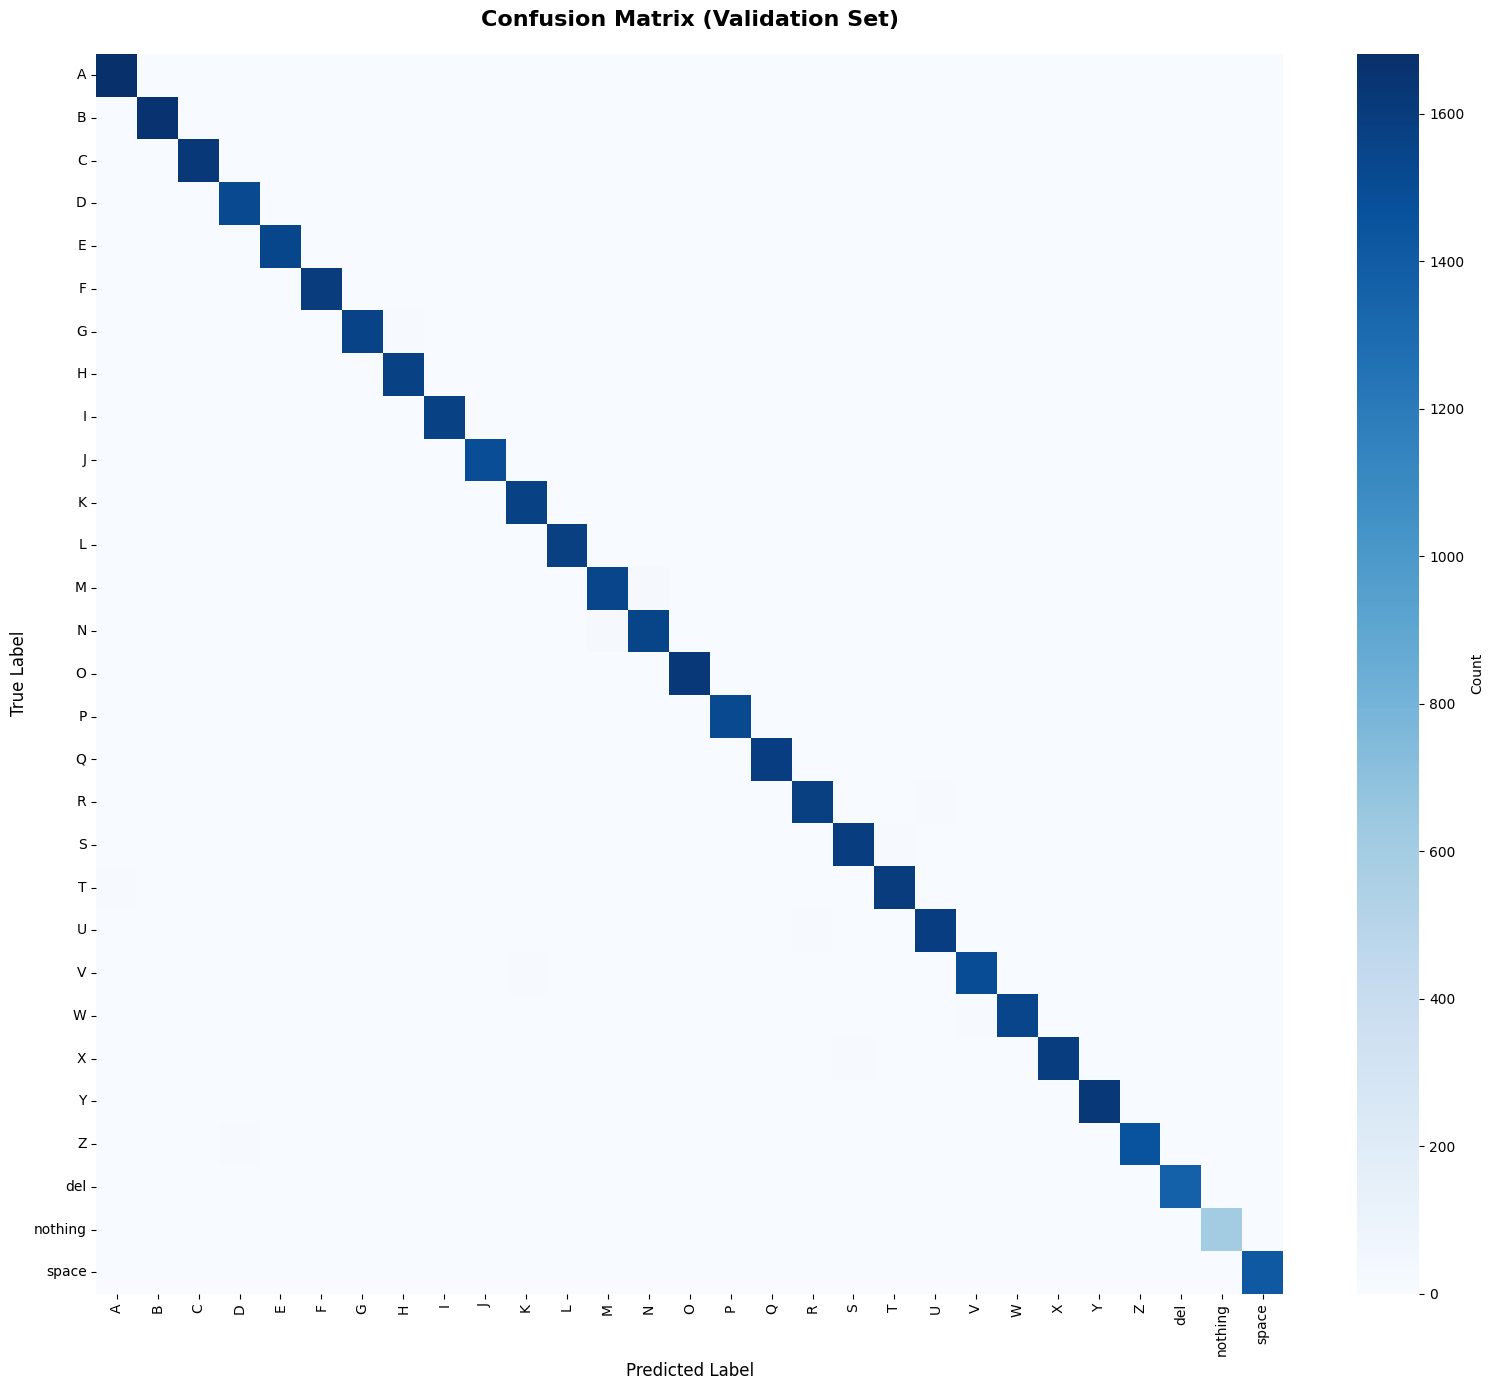


PER-CLASS ACCURACY
A              : 99.41% (1681/1691)
B              : 99.64% (1655/1661)
C              : 99.82% (1626/1629)
D              : 99.80% (1523/1526)
E              : 99.29% (1538/1549)
F              : 99.56% (1599/1606)
G              : 99.36% (1559/1569)
H              : 99.49% (1573/1581)
I              : 98.49% (1567/1591)
J              : 99.60% (1494/1500)
K              : 99.62% (1569/1575)
L              : 99.68% (1582/1587)
M              : 97.85% (1546/1580)
N              : 97.92% (1552/1585)
O              : 99.69% (1623/1628)
P              : 100.00% (1518/1518)
Q              : 99.62% (1585/1591)
R              : 98.50% (1580/1604)
S              : 98.21% (1593/1622)
T              : 99.07% (1596/1611)
U              : 98.94% (1588/1605)
V              : 98.75% (1500/1519)
W              : 99.29% (1546/1557)
X              : 98.46% (1594/1619)
Y              : 99.20% (1622/1635)
Z              : 98.58% (1461/1482)
del            : 99.71% (1363/1367)
nothing

In [ ]:
# === FIXED CONFUSION MATRIX & EVALUATION ===
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Load model if not in memory
if 'model' not in locals():
    from tensorflow.keras.models import load_model
    model_path = "/content/drive/MyDrive/asl_training_saves/asl_model_stage2.keras"
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)
    print("✅ Model loaded!")

# Get class names from Config
if hasattr(Config, 'LABEL_MAP') and Config.LABEL_MAP:
    class_names = list(Config.LABEL_MAP.values())
    num_classes = len(class_names)
    print(f"✅ Found {num_classes} classes")
else:
    print("⚠️ Config.LABEL_MAP not found. Using numbered classes.")
    # Get number of classes from model output
    num_classes = model.output_shape[-1]
    class_names = [f"Class_{i}" for i in range(num_classes)]
    Config.LABEL_MAP = {i: name for i, name in enumerate(class_names)}

print(f"Classes: {class_names}")

# Collect predictions from validation dataset
print("\n🔍 Generating predictions (this may take a while)...")
y_pred_list = []
y_true_list = []

# Make sure validation_steps is defined
if 'validation_steps' not in locals():
    if 'val_paths' in locals():
        validation_steps = len(val_paths) // Config.BATCH_SIZE
    else:
        print("⚠️ validation_steps not found, using default of 100")
        validation_steps = 100

# Iterate through validation dataset
batch_count = 0
for images, labels in val_ds.take(validation_steps):
    preds = model.predict(images, verbose=0)
    y_pred_list.extend(np.argmax(preds, axis=1))
    y_true_list.extend(np.argmax(labels.numpy(), axis=1))
    batch_count += 1
    if batch_count % 20 == 0:
        print(f"   Processed {batch_count}/{validation_steps} batches...")

y_pred = np.array(y_pred_list)
y_true = np.array(y_true_list)

print(f"\n✅ Predictions collected: {len(y_pred)} samples")

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print(report)

# Confusion Matrix
print("\n📊 Generating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

# Create figure
plt.figure(figsize=(16, 14))
sns.heatmap(cm, cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot=False,
            fmt='d',
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Validation Set)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)

class_correct = cm.diagonal()
class_total = cm.sum(axis=1)
class_accuracy = class_correct / class_total

for i, (name, acc) in enumerate(zip(class_names, class_accuracy)):
    print(f"{name:15s}: {acc:6.2%} ({int(class_correct[i]):4d}/{int(class_total[i]):4d})")

overall_acc = np.sum(class_correct) / np.sum(class_total)
print(f"\n{'Overall':15s}: {overall_acc:6.2%}")

# Model configuration summary
print("\n" + "="*60)
print("MODEL CONFIGURATION")
print("="*60)
print(f"Number of classes: {num_classes}")
print(f"Image size: {Config.IMG_SIZE}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Total parameters: {model.count_params():,}")
print("="*60)

***real camera prediction***

In [ ]:
# === CELL 9: ASL SENTENCE BUILDER (LIVE) ===

# This preserves your original class and logic but adds:
# - small prediction cache to reduce flicker (last N predictions)
# - uses the same Mediapipe Hands instance persisted across frames
# - safe resource cleanup and limited prints to avoid flooding output.

import gc
from collections import deque, Counter
from base64 import b64decode

# Keep mediator instance persistent and reuse model (already loaded)
# If you want to load the model from disk instead, do:
# model = tf.keras.models.load_model(Config.MODEL_PATH_KERAS)

# Webcam frame capture helper (Colab)
def capture_webcam_frame(quality=0.6):
    js = Javascript('''(async (quality) => {
        const video = document.createElement('video');
        const canvas = document.createElement('canvas');
        const stream = await navigator.mediaDevices.getUserMedia({video: {width: 640, height: 480}});
        video.srcObject = stream;
        await video.play();
        await new Promise(resolve => setTimeout(resolve, 100));
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        const data = canvas.toDataURL('image/jpeg', quality);
        stream.getTracks().forEach(track => track.stop());
        return data;
    })(%f)''' % quality)
    display(js)
    data = eval_js(js)
    binary = b64decode(data.split(',')[1])
    return cv2.imdecode(np.frombuffer(binary, np.uint8), cv2.IMREAD_COLOR)

# Improved builder with prediction cache
class ASLSentenceBuilder:
    def __init__(self, model, label_map, config=Config):
        self.model = model
        self.label_map = label_map
        self.sentence = ""
        self.current_word = ""
        self.last_letter = ""
        self.hold_counter = 0
        self.pred_queue = deque(maxlen=config.SMOOTH_WINDOW)
        self.pred_cache = deque(maxlen=6)  # short cache to reduce flicker
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5,
            model_complexity=0
        )
        print("✅ ASL Sentence Builder ready!")

    def extract_hand_region(self, frame):
        frame_small = cv2.resize(frame, (480, 360))
        img_rgb = cv2.cvtColor(frame_small, cv2.COLOR_BGR2RGB)
        results = self.hands.process(img_rgb)
        if not results.multi_hand_landmarks:
            return None
        h, w, _ = frame_small.shape
        hand_landmarks = results.multi_hand_landmarks[0]
        xs = [int(lm.x * w) for lm in hand_landmarks.landmark]
        ys = [int(lm.y * h) for lm in hand_landmarks.landmark]
        xmin, xmax = max(min(xs) - 20, 0), min(max(xs) + 20, w)
        ymin, ymax = max(min(ys) - 20, 0), min(max(ys) + 20, h)
        crop = frame_small[ymin:ymax, xmin:xmax]
        if crop.size == 0:
            return None
        img_resized = cv2.resize(crop, (Config.IMG_SIZE[0], Config.IMG_SIZE[1])).astype('float32')
        img_resized = preprocess_input(img_resized)
        return np.expand_dims(img_resized, axis=0)

    def predict(self, frame):
        hand_input = self.extract_hand_region(frame)
        if hand_input is None:
            return None, 0.0
        preds = self.model.predict(hand_input, verbose=0)[0]
        pred_class = int(np.argmax(preds))
        confidence = float(np.max(preds))
        letter = self.label_map.get(pred_class, "?")
        del hand_input, preds
        gc.collect()
        return letter, confidence

    def smooth_prediction(self, letter, confidence):
        # Confidence threshold check
        if letter is None or confidence < Config.CONFIDENCE_THRESHOLD:
            # push None in cache to smooth out temporary drops
            self.pred_cache.append(None)
            # pick most common non-None if any
            non_nulls = [p for p in self.pred_cache if p is not None]
            return Counter(non_nulls).most_common(1)[0][0] if non_nulls else None
        # Add to short cache and to longer pred_queue
        self.pred_cache.append(letter)
        self.pred_queue.append(letter)
        # Use majority from short pred_cache first (reduces flicker)
        if len(self.pred_cache) >= 3:
            most_cache = Counter(self.pred_cache).most_common(1)[0][0]
            # ensure pred_queue has enough entries for stability
            if len(self.pred_queue) >= 3:
                return Counter(self.pred_queue).most_common(1)[0][0]
            return most_cache
        return None

    def update_sentence(self, letter):
        if letter is None:
            self.hold_counter = 0
            return False
        if letter == self.last_letter:
            self.hold_counter += 1
            if self.hold_counter < Config.HOLD_FRAMES:
                return False
            self.hold_counter = 0
        else:
            self.hold_counter = 0
            self.last_letter = letter
        # Handle special commands
        if letter.lower() in ["space", "nothing"]:
            if self.current_word:
                self.sentence += self.current_word + " "
                self.current_word = ""
                return True
        elif letter.lower() in ["del", "delete"]:
            if self.current_word:
                self.current_word = self.current_word[:-1]
            elif self.sentence:
                words = self.sentence.strip().split()
                if words:
                    words.pop()
                    self.sentence = " ".join(words) + " " if words else ""
            return True
        else:
            self.current_word += letter.upper()
            return True
        return False

    def annotate_frame(self, frame, letter, confidence):
        display = cv2.resize(frame, (640, 480))
        h, w = display.shape[:2]
        # black background
        cv2.rectangle(display, (0,0), (w,120), (0,0,0), -1)
        if letter and confidence > 0:
            special = ["space", "nothing", "del", "delete"]
            pred_text = f"[{letter}]" if letter.lower() in special else letter.upper()
            cv2.putText(display, f"{pred_text} ({confidence:.2f})", (10,35),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 2)
        cv2.putText(display, f"Word: {self.current_word}_", (10,70),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,200,0), 2)
        full_text = self.sentence + self.current_word
        if len(full_text) > 50:
            full_text = "..." + full_text[-47:]
        cv2.putText(display, f"{full_text}", (10,105),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        return display

    def run(self, num_frames=50):
        print("\n🤟 ASL SENTENCE BUILDER - LIVE")
        for frame_idx in range(num_frames):
            try:
                # For Colab, capture_webcam_frame implementation may vary
                frame = capture_webcam_frame(quality=0.6)
                if frame is None:
                    continue
                letter, confidence = self.predict(frame)
                smoothed_letter = self.smooth_prediction(letter, confidence)
                self.update_sentence(smoothed_letter)
                display_frame = self.annotate_frame(frame, letter, confidence)
                clear_output(wait=True)
                print(f"Frame: {frame_idx + 1}/{num_frames}")
                if letter:
                    print(f"Sign: {letter} ({confidence:.2f})")
                print(f"Word: {self.current_word}")
                print(f"Sentence: {self.sentence}")
                cv2_imshow(display_frame)
                del frame, display_frame
                time.sleep(0.15)
                if frame_idx % 10 == 0:
                    gc.collect()
            except Exception as e:
                print(f"⚠ Error during live loop: {e}")
                continue
        final = self.sentence + self.current_word
        print(f"\n✅ FINAL: '{final}'")
        return final


builder = ASLSentenceBuilder(model=model, label_map=Config.LABEL_MAP)
final_sentence = builder.run(num_frames=40)
print(f"\n🎉 COMPLETE! Final sentence: '{final_sentence}'")


**intilize th3e builder**

In [ ]:
# === FIXED ASL SENTENCE BUILDER ===
import gc
import time
import numpy as np
import cv2
import mediapipe as mp
from collections import deque, Counter
from base64 import b64decode
from IPython.display import display, Javascript, clear_output
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

print("\n" + "="*60)
print("ASL SENTENCE BUILDER - SETUP")
print("="*60)

# Ensure Config has all required attributes
if not hasattr(Config, 'SMOOTH_WINDOW'):
    Config.SMOOTH_WINDOW = 5
if not hasattr(Config, 'CONFIDENCE_THRESHOLD'):
    Config.CONFIDENCE_THRESHOLD = 0.60
if not hasattr(Config, 'HOLD_FRAMES'):
    Config.HOLD_FRAMES = 8

print(f"✅ Configuration:")
print(f"   Smooth window: {Config.SMOOTH_WINDOW}")
print(f"   Confidence threshold: {Config.CONFIDENCE_THRESHOLD}")
print(f"   Hold frames: {Config.HOLD_FRAMES}")

# Load model if not in memory
if 'model' not in locals():
    from tensorflow.keras.models import load_model
    model_path = "/content/drive/MyDrive/asl_training_saves/asl_model_stage2.keras"
    print(f"\n📦 Loading model from {model_path}...")
    model = load_model(model_path)
    print("✅ Model loaded!")

# Webcam frame capture helper (Colab)
def capture_webcam_frame(quality=0.6):
    """Capture a single frame from webcam in Colab"""
    js = Javascript('''
    async function captureFrame(quality) {
        const video = document.createElement('video');
        const canvas = document.createElement('canvas');

        // Request webcam access
        const stream = await navigator.mediaDevices.getUserMedia({
            video: {width: 640, height: 480}
        });

        video.srcObject = stream;
        await video.play();

        // Wait for video to be ready
        await new Promise(resolve => setTimeout(resolve, 100));

        // Capture frame
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        // Convert to base64
        const data = canvas.toDataURL('image/jpeg', quality);

        // Stop camera
        stream.getTracks().forEach(track => track.stop());

        return data;
    }
    ''')

    display(js)
    data = eval_js(f'captureFrame({quality})')
    binary = b64decode(data.split(',')[1])
    return cv2.imdecode(np.frombuffer(binary, np.uint8), cv2.IMREAD_COLOR)


class ASLSentenceBuilder:
    """Real-time ASL sentence builder with smoothing and hand detection"""

    def __init__(self, model, label_map, config=Config):
        self.model = model
        self.label_map = label_map
        self.config = config

        # Sentence building state
        self.sentence = ""
        self.current_word = ""
        self.last_letter = ""
        self.hold_counter = 0

        # Prediction smoothing
        self.pred_queue = deque(maxlen=config.SMOOTH_WINDOW)
        self.pred_cache = deque(maxlen=6)

        # MediaPipe Hands
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5,
            model_complexity=0
        )

        print("✅ ASL Sentence Builder initialized!")

    def extract_hand_region(self, frame):
        """Extract and preprocess hand region from frame"""
        try:
            # Resize for faster processing
            frame_small = cv2.resize(frame, (480, 360))
            img_rgb = cv2.cvtColor(frame_small, cv2.COLOR_BGR2RGB)

            # Detect hand
            results = self.hands.process(img_rgb)
            if not results.multi_hand_landmarks:
                return None

            # Get bounding box
            h, w, _ = frame_small.shape
            hand_landmarks = results.multi_hand_landmarks[0]

            xs = [int(lm.x * w) for lm in hand_landmarks.landmark]
            ys = [int(lm.y * h) for lm in hand_landmarks.landmark]

            # Add padding
            xmin = max(min(xs) - 20, 0)
            xmax = min(max(xs) + 20, w)
            ymin = max(min(ys) - 20, 0)
            ymax = min(max(ys) + 20, h)

            # Crop hand region
            crop = frame_small[ymin:ymax, xmin:xmax]
            if crop.size == 0:
                return None

            # Resize and preprocess for model
            img_resized = cv2.resize(crop, self.config.IMG_SIZE)
            img_resized = img_resized.astype('float32')
            img_resized = preprocess_input(img_resized)

            return np.expand_dims(img_resized, axis=0)

        except Exception as e:
            return None

    def predict(self, frame):
        """Predict sign from frame"""
        hand_input = self.extract_hand_region(frame)
        if hand_input is None:
            return None, 0.0

        # Predict
        preds = self.model.predict(hand_input, verbose=0)[0]
        pred_class = int(np.argmax(preds))
        confidence = float(np.max(preds))
        letter = self.label_map.get(pred_class, "?")

        # Cleanup
        del hand_input, preds
        gc.collect()

        return letter, confidence

    def smooth_prediction(self, letter, confidence):
        """Smooth predictions to reduce flicker"""
        # Check confidence threshold
        if letter is None or confidence < self.config.CONFIDENCE_THRESHOLD:
            self.pred_cache.append(None)
            non_nulls = [p for p in self.pred_cache if p is not None]
            if non_nulls:
                return Counter(non_nulls).most_common(1)[0][0]
            return None

        # Add to caches
        self.pred_cache.append(letter)
        self.pred_queue.append(letter)

        # Use majority vote
        if len(self.pred_cache) >= 3:
            most_cache = Counter(self.pred_cache).most_common(1)[0][0]
            if len(self.pred_queue) >= 3:
                return Counter(self.pred_queue).most_common(1)[0][0]
            return most_cache

        return None

    def update_sentence(self, letter):
        """Update sentence based on detected letter"""
        if letter is None:
            self.hold_counter = 0
            return False

        # Check if same letter is held
        if letter == self.last_letter:
            self.hold_counter += 1
            if self.hold_counter < self.config.HOLD_FRAMES:
                return False
            self.hold_counter = 0
        else:
            self.hold_counter = 0
            self.last_letter = letter

        # Handle special commands
        letter_lower = letter.lower()

        if letter_lower in ["space", "nothing"]:
            if self.current_word:
                self.sentence += self.current_word + " "
                self.current_word = ""
                return True

        elif letter_lower in ["del", "delete"]:
            if self.current_word:
                self.current_word = self.current_word[:-1]
            elif self.sentence:
                words = self.sentence.strip().split()
                if words:
                    words.pop()
                    self.sentence = " ".join(words) + " " if words else ""
            return True

        else:
            self.current_word += letter.upper()
            return True

        return False

    def annotate_frame(self, frame, letter, confidence):
        """Add text overlay to frame"""
        display = cv2.resize(frame, (640, 480))
        h, w = display.shape[:2]

        # Black background for text
        cv2.rectangle(display, (0, 0), (w, 120), (0, 0, 0), -1)

        # Show prediction
        if letter and confidence > 0:
            special = ["space", "nothing", "del", "delete"]
            pred_text = f"[{letter}]" if letter.lower() in special else letter.upper()
            cv2.putText(display, f"Sign: {pred_text} ({confidence:.2f})",
                       (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)

        # Show current word
        cv2.putText(display, f"Word: {self.current_word}_",
                   (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 200, 0), 2)

        # Show sentence (truncate if too long)
        full_text = self.sentence + self.current_word
        if len(full_text) > 50:
            full_text = "..." + full_text[-47:]
        cv2.putText(display, full_text,
                   (10, 105), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        return display

    def run(self, num_frames=50):
        """Run live sentence builder"""
        print("\n" + "="*60)
        print("🤟 ASL SENTENCE BUILDER - LIVE MODE")
        print("="*60)
        print("Hold a sign steady to add it to your sentence")
        print(f"Running for {num_frames} frames...")
        print()

        for frame_idx in range(num_frames):
            try:
                # Capture frame
                frame = capture_webcam_frame(quality=0.6)
                if frame is None:
                    print(f"⚠️ Frame {frame_idx + 1}: No frame captured")
                    continue

                # Predict
                letter, confidence = self.predict(frame)
                smoothed_letter = self.smooth_prediction(letter, confidence)

                # Update sentence
                self.update_sentence(smoothed_letter)

                # Display
                display_frame = self.annotate_frame(frame, letter, confidence)

                clear_output(wait=True)
                print(f"Frame: {frame_idx + 1}/{num_frames}")
                if letter:
                    print(f"Detected: {letter} ({confidence:.2%})")
                print(f"Current word: {self.current_word}")
                print(f"Sentence: {self.sentence}")

                cv2_imshow(display_frame)

                # Cleanup
                del frame, display_frame
                time.sleep(0.15)

                if frame_idx % 10 == 0:
                    gc.collect()

            except KeyboardInterrupt:
                print("\n⏹️ Stopped by user")
                break
            except Exception as e:
                print(f"⚠️ Error at frame {frame_idx + 1}: {e}")
                continue

        # Final result
        final = self.sentence + self.current_word
        print("\n" + "="*60)
        print(f"✅ SESSION COMPLETE!")
        print(f"📝 Final sentence: '{final}'")
        print("="*60)

        return final

    def cleanup(self):
        """Release resources"""
        if hasattr(self, 'hands'):
            self.hands.close()
        gc.collect()


# === USAGE ===
print("\n🚀 Creating ASL Sentence Builder...")
builder = ASLSentenceBuilder(model=model, label_map=Config.LABEL_MAP)

print("\n▶️ Ready to start! Run the next cell to begin live capture.")
print("="*60)


ASL SENTENCE BUILDER - SETUP
✅ Configuration:
   Smooth window: 5
   Confidence threshold: 0.6
   Hold frames: 8

🚀 Creating ASL Sentence Builder...
✅ ASL Sentence Builder initialized!

▶️ Ready to start! Run the next cell to begin live capture.


**call the builder**

Frame: 40/40
Current word: 
Sentence: 


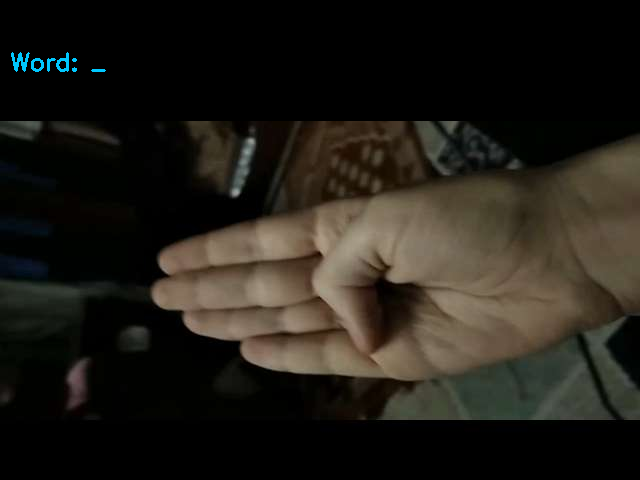


✅ SESSION COMPLETE!
📝 Final sentence: ''


ValueError: Closing SolutionBase._graph which is already None

In [12]:
# === RUN LIVE ASL PREDICTION ===
# Run this cell after initializing the builder

print("🎥 Starting live ASL sentence builder...")
print("📌 Tips:")
print("   - Hold your hand steady in front of the camera")
print("   - Make sure your hand is well-lit")
print("   - Hold each sign for a few seconds")
print("   - Use 'space' sign to add a word")
print("   - Use 'del' sign to delete")
print()

# Start live capture (adjust num_frames as needed)
final_sentence = builder.run(num_frames=40)

# Cleanup
builder.cleanup()

print(f"\n🎉 Complete! Your sentence: '{final_sentence}'")